In [ ]:
from google.colab import drive
drive.mount('/gdrive')

!pip -q install nilearn nibabel fastai==2.3.0 

Mounted at /gdrive
     |████████████████████████████████| 4.9MB 6.5MB/s 
     |████████████████████████████████| 194kB 41.4MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 12.8MB 266kB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
!cp /gdrive/MyDrive/Training_Batch1.zip .
!unzip -q -u /content/Training_Batch1.zip  -d /content/batch1/

%cd "/content/batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1"
!mv * ../../../../../../
%cd /content
%rm -rf /content/batch1/media

/content/batch1/media/nas/01_Datasets/CT/LITS/Training Batch 1
/content


In [ ]:
!cp /gdrive/MyDrive/Training_Batch2.zip .
!unzip -q -u /content/Training_Batch2.zip  -d /content/batch2/
%cd "/content/batch2/media/nas/01_Datasets/CT/LITS/Training Batch 2"
!mv * ../../../../../../
%cd /content
%rm -rf /content/batch2/media

/content/batch2/media/nas/01_Datasets/CT/LITS/Training Batch 2
/content


In [ ]:
%cd /content/batch2/
!mv * ../batch1/
%cd /content

/content/batch2
/content


In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image

In [ ]:
# !pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
# !pip install --upgrade kornia > /dev/null
# !pip install allennlp==1.1.0.rc4 > /dev/null
# !pip install --upgrade fastai > /dev/null
import fastai; fastai.__version__

'2.3.0'

In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [ ]:
file_list = []

for dirname, _, filenames in os.walk(os.path.abspath('batch1/')):
    for filename in filenames:
        file_list.append((dirname,filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    
df_files[0:10]

,dirname,filename
0,/content/batch1,volume-119.nii
1,/content/batch1,segmentation-31.nii
2,/content/batch1,volume-7.nii
3,/content/batch1,segmentation-119.nii
4,/content/batch1,segmentation-53.nii
5,/content/batch1,segmentation-110.nii
6,/content/batch1,volume-67.nii
7,/content/batch1,volume-58.nii
8,/content/batch1,volume-77.nii
9,/content/batch1,segmentation-17.nii


In [ ]:
df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "/content/batch1/"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
print(len(df_files))
df_files

87


,dirname,filename,mask_dirname,mask_filename
0,/content/batch1,volume-1.nii,/content/batch1/,segmentation-1.nii
1,/content/batch1,volume-10.nii,/content/batch1/,segmentation-10.nii
2,/content/batch1,volume-101.nii,/content/batch1/,segmentation-101.nii
3,/content/batch1,volume-102.nii,/content/batch1/,segmentation-102.nii
4,/content/batch1,volume-104.nii,/content/batch1/,segmentation-104.nii
...,...,...,...,...
82,/content/batch1,volume-93.nii,/content/batch1/,segmentation-93.nii
83,/content/batch1,volume-94.nii,/content/batch1/,segmentation-94.nii
84,/content/batch1,volume-96.nii,/content/batch1/,segmentation-96.nii
85,/content/batch1,volume-97.nii,/content/batch1/,segmentation-97.nii


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [ ]:
sample = 0
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
sample_ct.shape, sample_mask.shape

((512, 512, 75), (512, 512, 75))

In [ ]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


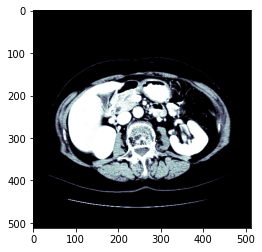

In [ ]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

plt.imshow(tensor(sample_ct[...,50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

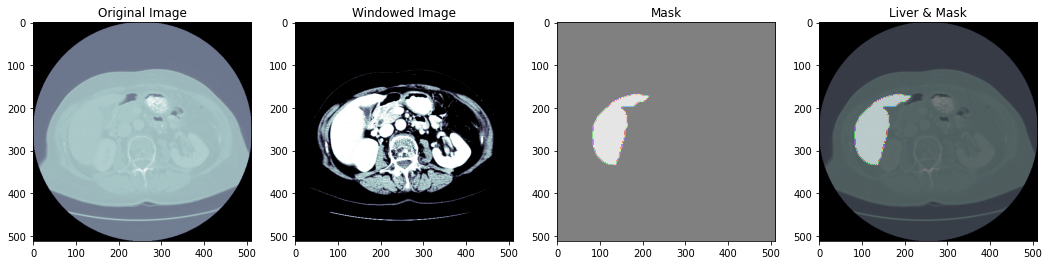

In [ ]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

[[     0 252049]
 [     1  10095]]


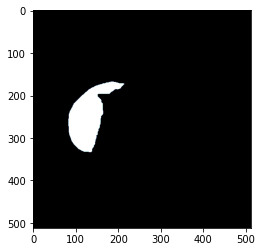

In [ ]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)
plt.imshow(mask , cmap = 'bone')

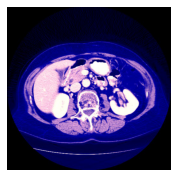

In [ ]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [ ]:
GENERATE_JPG_FILES = True   # warning: generation takes ~ 1h

if (GENERATE_JPG_FILES):
  path = Path(".")
  os.makedirs('train_images',exist_ok=True)
  os.makedirs('train_masks',exist_ok=True)
  
  for ii in tqdm(range(0, len(df_files), 3)): # take 1/3 nii files for training
    img_path = df_files.loc[ii,'dirname']+'/'+df_files.loc[ii,'filename']
    mask_path = df_files.loc[ii,'mask_dirname']+df_files.loc[ii,'mask_filename']
    curr_ct = read_nii(img_path)
    curr_mask = read_nii(mask_path)
    curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
    curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

    for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
      data = tensor(curr_ct[...,curr_slice].astype(np.float32))
      mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
      data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
      mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
    os.remove(img_path)
    os.remove(mask_path)


In [ ]:
bs = 16
im_size = 128

codes = np.array(["background","liver"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')

0
1


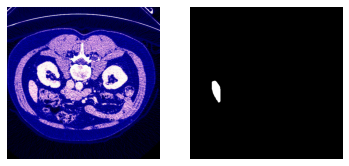

In [ ]:
idx=16
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    print(i)
    ax.axis('off')
    ax.imshow(imgs[i] , cmap='gray')

In [ ]:
os.makedirs('images',exist_ok=True)
os.makedirs('masks',exist_ok=True)

for idx in tqdm(range(len(ds.items))):
  imgs = [ds[idx][0],ds[idx][1]]
  im, msk = np.array(imgs[0]), np.array(imgs[1])
  if msk.sum() == 0:
    continue
  plt.imsave("images/" + str(idx) + ".png", im)
  plt.imsave("masks/" + str(idx) + ".png", msk)

In [ ]:
!zip -q -r train_masks.zip "masks/"
!zip -q -r train_img.zip "images/"

!cp train_img.zip "/gdrive/MyDrive/Assignment 2/data/lits/imgs.zip"
!cp train_masks.zip "/gdrive/MyDrive/Assignment 2/data/lits/masks.zip"

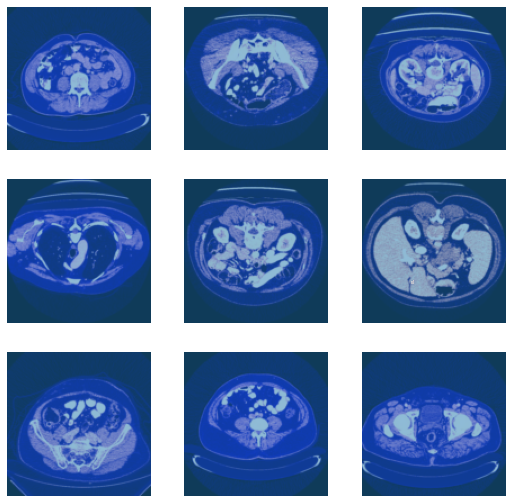

In [ ]:
dls = db.dataloaders(path/'train_images', bs = bs) #, num_workers=0
dls.show_batch()